# Tune_lgb
* 이전결과 : 0.3913216698(n_estimator 1000까지)/ 0.404706925(early_stopping까지)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss


import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
path = "./data/"
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_df.shape, test_df.shape

((199991, 22), (10009, 21))

## DATA Setting

In [6]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [7]:
train_df = del_outlier(train_df, min=-60, max=60)

In [8]:
train_df.shape

(199805, 22)

In [9]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [10]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [11]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [12]:
train_df = add_minus_feature_all(train_df)
test_df = add_minus_feature_all(test_df,True)

In [13]:
train_X = train_df.drop(columns=['type', 'type_num'], axis=1)
train_y = train_df['type_num']
test_X = test_df

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

## Modeling
* cv한 결과에서 받아옴 -> 결과 0.349561 but lr = 0.1로 너무 빨리 종료됨 lr 조정후 다시시도

In [15]:
param = {'num_leaves': 255,
 'min_child_samples': 40,
 'max_depth': 8,
 'learning_rate': 0.05,
 'lambda_l2': 3,
 'lambda_l1': 9}

In [26]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 255, min_child_samples = 40,
                            max_depth = 8, learning_rate = 0.1,
                            lambda_l2 = 3, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [35]:
lgbm_c.fit(X_train, y_train, eval_set = [(X_test, y_test)],eval_names= 'valid', 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	valid's multi_logloss: 0.355422
[200]	valid's multi_logloss: 0.349614
[300]	valid's multi_logloss: 0.350395
Did not meet early stopping. Best iteration is:
[243]	valid's multi_logloss: 0.349561


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=9, lambda_l2=3,
               learning_rate=0.1, max_depth=8, min_child_samples=40,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
               n_jobs=-1, num_leaves=255, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [36]:
train_y_pred = lgbm_c.predict_proba(X_test)

from sklearn.metrics import log_loss
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.3489389318790384

In [37]:
train_y_pred

array([[7.93182691e-03, 1.47024160e-04, 4.93338825e-05, ...,
        5.01181554e-05, 1.32473671e-04, 3.20236926e-04],
       [8.12774935e-04, 2.01454888e-04, 4.84129742e-05, ...,
        4.36036170e-05, 1.21330132e-04, 1.97036989e-01],
       [2.82099021e-05, 8.65868578e-06, 4.40205146e-06, ...,
        3.18634823e-06, 1.21217960e-05, 2.18489554e-05],
       ...,
       [8.08184829e-05, 7.34896082e-05, 5.04386699e-04, ...,
        2.81816036e-04, 3.37385219e-05, 5.13531270e-05],
       [9.18553996e-06, 6.48557989e-06, 1.41714578e-06, ...,
        3.48696796e-06, 2.75714487e-06, 7.81066242e-05],
       [5.48772401e-04, 3.98834578e-05, 2.15742142e-05, ...,
        1.82698104e-05, 4.09333342e-05, 2.64535895e-02]])

In [38]:
test_y_pred = lgbm_c.predict_proba(test_X)

In [39]:
test_y_pred

array([[5.51394570e-05, 6.37628907e-05, 8.06277771e-04, ...,
        3.16980411e-04, 4.13802228e-03, 7.84962662e-05],
       [3.38862998e-04, 3.57660650e-04, 9.40593914e-05, ...,
        1.24404940e-04, 1.11963959e-03, 4.93638646e-04],
       [1.69421649e-05, 8.13806558e-06, 4.08609525e-06, ...,
        2.38621186e-06, 3.14479554e-05, 1.01574824e-05],
       ...,
       [6.90274321e-06, 7.44219097e-06, 1.03435255e-06, ...,
        2.45922573e-06, 2.53841674e-06, 4.65403238e-04],
       [7.76717374e-06, 8.02547573e-06, 1.08875452e-06, ...,
        2.62843599e-06, 2.31413784e-06, 1.41971915e-04],
       [1.64381135e-04, 6.14901910e-06, 4.23383779e-06, ...,
        5.04191235e-06, 6.92702600e-06, 1.49036492e-05]])

### feature_importance

In [20]:
pi_df = pd.DataFrame(lgbm_c.feature_importances_, index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df

,importance
fiberID,11760
fiberMag_i-z,4767
modelMag_i-z,4668
psfMag_i-z,4664
petroMag_i-z,4398
psfMag_r-i,4242
fiberMag_u-g,4231
psfMag_g-r,4218
psfMag_u-g,4204
petroMag_u-g,4013


### 예측결과에 대해
잘된예측 : 1,3,4,5,6,8,9,10,14,15,16,18  
중간예측 : 0,2,7,13  
망한예측 : 11,12,17

In [21]:
train_y_pred = lgbm_c.predict(X_test)

In [34]:
train_y_pred.shape

(59942,)

In [22]:
cm_result = pd.DataFrame(confusion_matrix(y_test,train_y_pred))

In [23]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,311,0,0,0,14,44,1,141,41,0,0,31,0,1,27,4,0,0,33
1,1,1879,0,0,0,1,1,3,12,0,1,4,0,0,0,0,3,0,46
2,0,0,77,63,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0
3,1,0,35,626,0,0,0,0,1,0,105,0,0,0,0,0,0,0,0
4,0,0,0,0,4246,48,0,0,8,0,0,8,0,0,0,75,0,0,0
5,40,0,0,0,125,3697,0,57,42,0,0,6,0,0,0,70,0,0,11
6,2,31,0,0,6,4,10894,2,71,2,1,57,0,86,14,13,0,0,1
7,173,0,0,0,0,201,0,686,18,0,0,2,0,0,0,1,0,0,315
8,23,12,2,2,26,205,87,30,13290,1,12,164,0,68,64,17,12,0,878
9,0,0,0,0,0,0,0,0,3,35,0,0,0,0,0,0,0,0,0


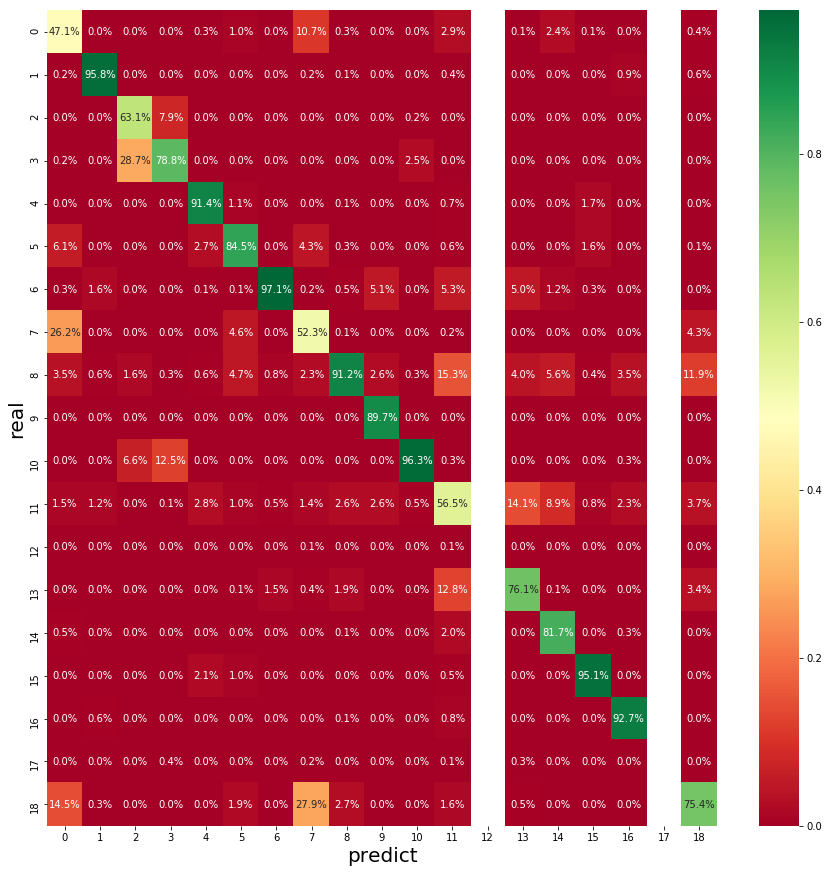

In [24]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [45]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 255, min_child_samples = 40,
                            max_depth = 8, learning_rate = 0.1,
                            lambda_l2 = 3, lambda_l1 = 9,
                            n_estimators=2000, random_state = 42)

In [46]:
lgbm_c.fit(train_X, train_y, eval_set = [(train_X, train_y)],eval_names= 'valid', 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	valid's multi_logloss: 0.291435
[200]	valid's multi_logloss: 0.240178
[300]	valid's multi_logloss: 0.205801
[400]	valid's multi_logloss: 0.181374
[500]	valid's multi_logloss: 0.164057
[600]	valid's multi_logloss: 0.150964
[700]	valid's multi_logloss: 0.141201
[800]	valid's multi_logloss: 0.133643
[900]	valid's multi_logloss: 0.127699
[1000]	valid's multi_logloss: 0.123496
[1100]	valid's multi_logloss: 0.120537
[1200]	valid's multi_logloss: 0.118954
[1300]	valid's multi_logloss: 0.118954
[1400]	valid's multi_logloss: 0.118954
[1500]	valid's multi_logloss: 0.118954
[1600]	valid's multi_logloss: 0.118954
[1700]	valid's multi_logloss: 0.118954
[1800]	valid's multi_logloss: 0.118954
[1900]	valid's multi_logloss: 0.118954
[2000]	valid's multi_logloss: 0.118954
Did not meet early stopping. Best iteration is:
[1704]	valid's multi_logloss: 0.118954


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=9, lambda_l2=3,
               learning_rate=0.1, max_depth=8, min_child_samples=40,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
               n_jobs=-1, num_leaves=255, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [47]:
f_train_y_pred = lgbm_c.predict_proba(train_X)

In [48]:
y_pred = lgbm_c.predict_proba(test_X)

In [49]:
y_pred

array([[4.30308466e-05, 7.18669023e-05, 9.29118307e-04, ...,
        3.25654315e-04, 1.76464319e-03, 4.51124853e-05],
       [1.60443355e-04, 1.85817437e-04, 4.62991644e-05, ...,
        1.13856022e-04, 9.67996320e-04, 1.92335364e-04],
       [3.42757300e-06, 2.65847934e-06, 9.35617329e-07, ...,
        1.10865115e-06, 9.39440439e-06, 2.11749604e-06],
       ...,
       [2.75604164e-06, 2.46366889e-06, 2.85720572e-07, ...,
        5.95532817e-07, 6.08830949e-07, 1.47724689e-04],
       [1.45185354e-06, 2.49098180e-06, 2.71972286e-07, ...,
        6.89253276e-07, 6.48896281e-07, 2.73143908e-05],
       [5.49549358e-05, 1.36651599e-06, 1.03435943e-06, ...,
        1.85359357e-06, 2.10060297e-06, 4.73220788e-06]])

In [50]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)